In [1]:
import time
import copy
from IPython import display
from collections import defaultdict
import numpy as np

# Simple RL
from simple_rl.tasks import GridWorldMDP, NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationStateClass import NavigationWorldState
from simple_rl.planning import ValueIteration

# Torch
import torch
import torch.optim as optim
from torch import FloatTensor
from torch.autograd import Variable
import torch.multiprocessing as mp
mp.set_start_method('fork')

# https://github.com/pandas-profiling/pandas-profiling/issues/68
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../utils/")
import plotting_wrapper as Plotting

In [3]:
def test(phi_S, w):
    print("start")
    phi_S.mm(w)
    print("end")
    
dtype = torch.float
phi_dim = 10
phi_S = torch.rand(10000, phi_dim).type(dtype)
w = Variable(-0.001 * torch.ones(phi_dim, 1).type(dtype), requires_grad=True)
processes = []
for p_idx in range(8):
    p = mp.Process(target=test, args=(phi_S, w))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

start
start
start
start
start
start
start
start


In [3]:
def run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, n_iters,
                        dtype, given_goal_idx=None, verbose=False):

    nS, nA = len(S), len(A)
    
    # Initialize Pi, V, & Q.
    Pi = torch.ones(nS, nA, dtype=dtype) / nA
#     V = torch.zeros(nS, dtype=dtype)
#     Q = torch.zeros(nS, nA, dtype=dtype)
    V = R.clone() # trick to initialize terminal states' value without running VI on it (no need for absorbing state).
    Q = R.reshape(nS, 1).repeat(1, nA).clone()
    
    # Force given goals to have 0 value
    if given_goal_idx is not None:
        V[given_goal_idx] = 0
        
    # Value iteration
    for _ in range(n_iters):
        for si, s in enumerate(S):
            
            # No need to compute value for terminal and given goal states.
            if s.is_terminal() or si == given_goal_idx:
                continue 
                
            for ai, a in enumerate(A):
                for sp in T[s][a]:
                    if verbose: print(s, "-", "{:5s}".format(a), "->", sp, "R: ", int(R[si]), "V_sp: ", int(V[s_to_idx[sp]]))
                    Q[si, ai] = R[si].clone() + \
                        gamma * T[s][a][sp] * V[s_to_idx[sp]].clone()
            Pi[si, :] = expl_policy(Q[si, :].clone())
            V[si] = Pi[si, :].clone().dot(Q[si, :].clone())
    return Pi, V, Q

In [4]:
def get_toy_irl_problem(width, height, goal_loc):
    
    nvmdp = NavigationWorldMDP(width, height, 
                               nav_cell_types=list(range(int(width*height-1))),
                               nav_cell_p_or_locs=[[(x,y)] for y in range(height, 0, -1)
                                                   for x in range(1, width+1) if not (x,y) == goal_loc],
                               nav_cell_rewards=[0.]*(int(width*height-1)),
                               goal_cell_types=['green'], 
                               goal_cell_rewards=[1.0], 
                               goal_cell_locs=[[goal_loc]])
    
    def phi(s): return nvmdp.feature_at_state(s,
                        feature_type="indicator",
                        incl_cell_distances=False,
                        incl_goal_indicator=True,
                        incl_goal_distances=False,
                        normalize_distance=False, dtype=np.float)
    
    S = nvmdp.get_all_states()
    T = nvmdp.get_trans_dict()
    A = nvmdp.get_actions()
    s_to_idx = {s:idx for idx,s in enumerate(S)}
    return nvmdp, S, A, T, phi, s_to_idx

def get_toy_irl_problem_no_goal(width, height):
    
    nvmdp = NavigationWorldMDP(width, height, 
                               nav_cell_types=list(range(int(width*height))),
                               nav_cell_p_or_locs=[[(x,y)] for y in range(height, 0, -1) 
                                                   for x in range(1, width+1)], #  if not (x,y) == goal_loc],
                               nav_cell_rewards=[0.]*(int(width*height)),
                               goal_cell_types=[], #['green'], 
                               goal_cell_rewards=[], #[1.0], 
                               goal_cell_locs=[]) #[[goal_loc]])
    
    def phi(s): return nvmdp.feature_at_state(s,
                        feature_type="indicator",
                        incl_cell_distances=False,
                        incl_goal_indicator=True,
                        incl_goal_distances=False,
                        normalize_distance=False, dtype=np.float)
    
    S = nvmdp.get_all_states()
    T = nvmdp.get_trans_dict()
    A = nvmdp.get_actions()
    s_to_idx = {s:idx for idx,s in enumerate(S)}
    return nvmdp, S, A, T, phi, s_to_idx

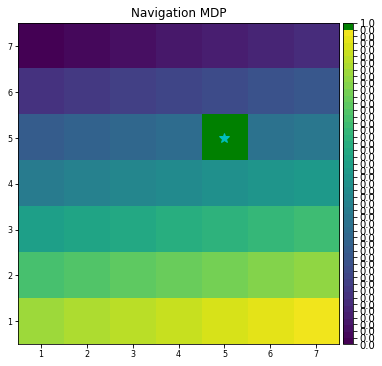

In [5]:
nvmdp, S, A, T, phi, s_to_idx = get_toy_irl_problem(7, 7, (5,5))
nvmdp.visualize_grid(show_colorbar=True, show_rewards_colorbar=True)

gamma = 0.80
dtype = torch.float
phi_dim = len(phi(S[0]))
boltzmann_beta = 10.
boltzmann_expl_policy = lambda Q, beta=boltzmann_beta: (beta*Q).softmax(dim=0)
argmax_expl_policy = lambda Q: torch.eye(len(Q))[Q.argmax()]

phi_S = torch.Tensor([phi(s) for s in S]).type(dtype)
w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
R_diff = torch.mm(phi_S, w)
R_const = torch.Tensor(len(S), 1).normal_(0, 0.01).type(dtype)
R_true = torch.Tensor([nvmdp.cell_type_rewards[cell_id] for cell_id in np.nditer(nvmdp.map_state_cell_id)]).type(dtype)

vi_params = dict(S=S, A=A, R=R_true, T=T, s_to_idx=s_to_idx,
                 expl_policy=argmax_expl_policy, gamma=gamma, dtype=dtype, n_iters=1)

In [6]:
def exp_vi(vi_params, R, n_iters):
    
    vi_params["n_iters"] = n_iters
    vi_params["R"] = R
    
    t_ = time.time()
    Pi, V, Q = run_value_iteration(**vi_params)
    return time.time()-t_, Pi, V, Q

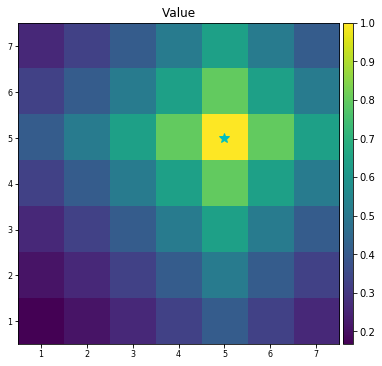

tensor([[0.2618, 0.3276, 0.4096, 0.5120, 0.6400, 0.5120, 0.4096],
        [0.3276, 0.4096, 0.5120, 0.6400, 0.8000, 0.6400, 0.5120],
        [0.4096, 0.5120, 0.6400, 0.8000, 1.0000, 0.8000, 0.6400],
        [0.3276, 0.4096, 0.5120, 0.6400, 0.8000, 0.6400, 0.5120],
        [0.2620, 0.3277, 0.4096, 0.5120, 0.6400, 0.5120, 0.4096],
        [0.2093, 0.2621, 0.3277, 0.4096, 0.5120, 0.4096, 0.3276],
        [0.1664, 0.2093, 0.2620, 0.3276, 0.4096, 0.3276, 0.2618]])

In [7]:
vi_params["expl_policy"] = lambda Q: boltzmann_expl_policy(Q, 100)
tdiff, Pi, V, Q = exp_vi(vi_params, R_true, 10)
nvmdp.visualize_grid(V.reshape(7,7), cmap=None, show_colorbar=True, title="Value")
V.reshape(7,7)

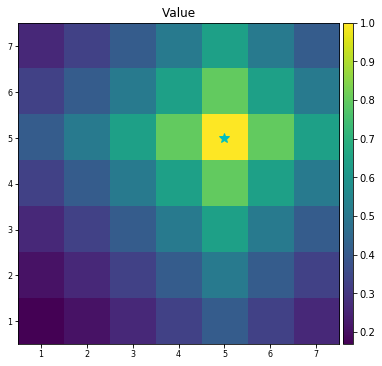

tensor([[0.2621, 0.3277, 0.4096, 0.5120, 0.6400, 0.5120, 0.4096],
        [0.3277, 0.4096, 0.5120, 0.6400, 0.8000, 0.6400, 0.5120],
        [0.4096, 0.5120, 0.6400, 0.8000, 1.0000, 0.8000, 0.6400],
        [0.3277, 0.4096, 0.5120, 0.6400, 0.8000, 0.6400, 0.5120],
        [0.2621, 0.3277, 0.4096, 0.5120, 0.6400, 0.5120, 0.4096],
        [0.2097, 0.2621, 0.3277, 0.4096, 0.5120, 0.4096, 0.3277],
        [0.1678, 0.2097, 0.2621, 0.3277, 0.4096, 0.3277, 0.2621]])

In [8]:
vi_params["expl_policy"] = argmax_expl_policy
tdiff, Pi, V, Q = exp_vi(vi_params, R_true, 10)
nvmdp.visualize_grid(V.reshape(7,7), cmap=None, show_colorbar=True, title="Value")
V.reshape(7,7)

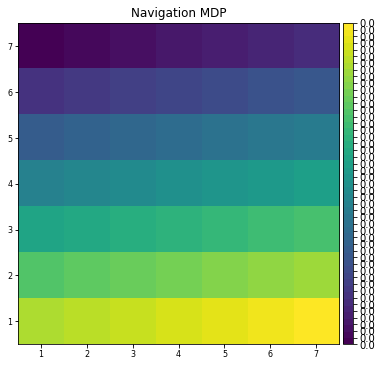

In [9]:
nvmdp, S, A, T, phi, s_to_idx = get_toy_irl_problem_no_goal(7, 7)
nvmdp.visualize_grid(show_colorbar=True, show_rewards_colorbar=True)

gamma = 0.80
dtype = torch.float
phi_dim = len(phi(S[0]))
boltzmann_beta = 10.
boltzmann_expl_policy = lambda Q, beta=boltzmann_beta: (beta*Q).softmax(dim=0)
argmax_expl_policy = lambda Q: torch.eye(len(Q))[Q.argmax()]

phi_S = torch.Tensor([phi(s) for s in S]).type(dtype)
w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
R_diff = torch.mm(phi_S, w)
R_const = torch.Tensor(len(S), 1).normal_(0, 0.01).type(dtype)
R_true = torch.Tensor([nvmdp.cell_type_rewards[cell_id] for cell_id in np.nditer(nvmdp.map_state_cell_id)]).type(dtype)

vi_params = dict(S=S, A=A, R=R_true, T=T, s_to_idx=s_to_idx,
                 expl_policy=argmax_expl_policy, gamma=gamma, dtype=dtype, n_iters=1)

In [10]:
vi_params["expl_policy"] = lambda Q: boltzmann_expl_policy(Q, 1)
# w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
w = Variable(torch.ones(phi_dim, 1).type(dtype), requires_grad=True)
# w = Variable(torch.zeros(phi_dim, 1).type(dtype), requires_grad=True)

optimizer_fn = lambda params: optim.SGD(params, lr=0.1, weight_decay=0.)
optimizer = optimizer_fn([w])

R_diff = torch.mm(phi_S, w)
tdiff, Pi, V, Q = exp_vi(vi_params, R_diff, 100)
V.reshape(7,7)

tensor([[5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000],
        [5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000],
        [5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000],
        [5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000],
        [5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000],
        [5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000],
        [5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000]],
       grad_fn=<AsStridedBackward>)

In [11]:
loss = -torch.log(Pi[24,2])
loss.backward()

In [12]:
w.grad.reshape(7,7).data.numpy().round(2)

array([[-0.01, -0.01, -0.  ,  0.02,  0.02,  0.01,  0.01],
       [-0.02, -0.02, -0.02,  0.05,  0.04,  0.02,  0.01],
       [-0.04, -0.07, -0.11,  0.21,  0.11,  0.05,  0.02],
       [-0.06, -0.18, -0.68,  0.  ,  0.26,  0.08,  0.03],
       [-0.04, -0.07, -0.11,  0.21,  0.11,  0.05,  0.02],
       [-0.02, -0.02, -0.02,  0.05,  0.04,  0.02,  0.01],
       [-0.01, -0.01, -0.  ,  0.02,  0.02,  0.01,  0.01]], dtype=float32)

In [13]:
optimizer.zero_grad()
R_diff = torch.mm(phi_S, w)
tdiff, Pi, V, Q = exp_vi(vi_params, R_diff, 100)
loss = -torch.log(Pi[24,3])
loss.backward()

In [14]:
w.grad.reshape(7,7).data.numpy().round(2)

array([[ 0.01,  0.01,  0.02,  0.02, -0.  , -0.01, -0.01],
       [ 0.01,  0.02,  0.04,  0.05, -0.02, -0.02, -0.02],
       [ 0.02,  0.05,  0.11,  0.21, -0.11, -0.07, -0.04],
       [ 0.03,  0.08,  0.26, -0.  , -0.68, -0.18, -0.06],
       [ 0.02,  0.05,  0.11,  0.21, -0.11, -0.07, -0.04],
       [ 0.01,  0.02,  0.04,  0.05, -0.02, -0.02, -0.02],
       [ 0.01,  0.01,  0.02,  0.02, -0.  , -0.01, -0.01]], dtype=float32)

In [15]:
optimizer.zero_grad()
R_diff = torch.mm(phi_S, w)
tdiff, Pi, V, Q = exp_vi(vi_params, R_diff, 1)
loss = -torch.log(Pi[24,2])
loss.backward()

In [16]:
w.grad.reshape(7,7).data.numpy().round(2)

array([[-0.02,  0.  ,  0.03,  0.04,  0.  ,  0.  ,  0.  ],
       [-0.05, -0.04,  0.03,  0.13,  0.  ,  0.  ,  0.  ],
       [-0.07, -0.12, -0.07,  0.33, -0.  ,  0.  ,  0.  ],
       [-0.06, -0.18, -0.47,  0.  ,  0.07,  0.  ,  0.  ],
       [-0.  , -0.  ,  0.  ,  0.07,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]], dtype=float32)

In [17]:
w.grad.reshape(7,7)

tensor([[-0.0241,  0.0012,  0.0339,  0.0423,  0.0030,  0.0000,  0.0000],
        [-0.0529, -0.0379,  0.0343,  0.1266,  0.0018,  0.0000,  0.0000],
        [-0.0748, -0.1169, -0.0655,  0.3294, -0.0024,  0.0000,  0.0000],
        [-0.0627, -0.1840, -0.4749,  0.0011,  0.0722,  0.0000,  0.0000],
        [-0.0043, -0.0026,  0.0035,  0.0722,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

In [18]:
w.reshape(7,7)

tensor([[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]], grad_fn=<AsStridedBackward>)

In [19]:
optimizer.step()

In [20]:
w.reshape(7,7)

tensor([[1.0024, 0.9999, 0.9966, 0.9958, 0.9997, 1.0000, 1.0000],
        [1.0053, 1.0038, 0.9966, 0.9873, 0.9998, 1.0000, 1.0000],
        [1.0075, 1.0117, 1.0066, 0.9671, 1.0002, 1.0000, 1.0000],
        [1.0063, 1.0184, 1.0475, 0.9999, 0.9928, 1.0000, 1.0000],
        [1.0004, 1.0003, 0.9996, 0.9928, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],
       grad_fn=<AsStridedBackward>)

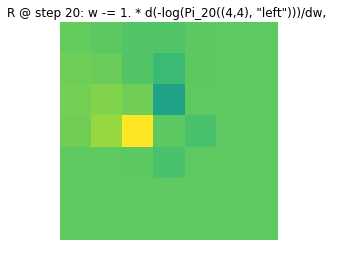

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=-2.,vmax=2.)
gif_images = []
for i in range(20):
    print(i,)
    optimizer.step()
#     nvmdp.visualize_grid(torch.mm(phi_S, w).reshape(7,7).data.numpy(), state_space_cmap=False, 
#                          cmap=plt.cm.viridis, show_colorbar=True, title="Value")
    ax = plt.gca()
    
    plt.imshow(torch.mm(phi_S, w).reshape(7,7).data.numpy(), cmap=plt.cm.viridis, norm=norm)
    plt.title("R @ step {}: w -= 1. * d(-log(Pi_20((4,4), \"left\")))/dw, ".format(i+1))
    plt.axis("off")
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    gif_images.append(Plotting.read_pil_image_from_plt(plt))
plt.clf()

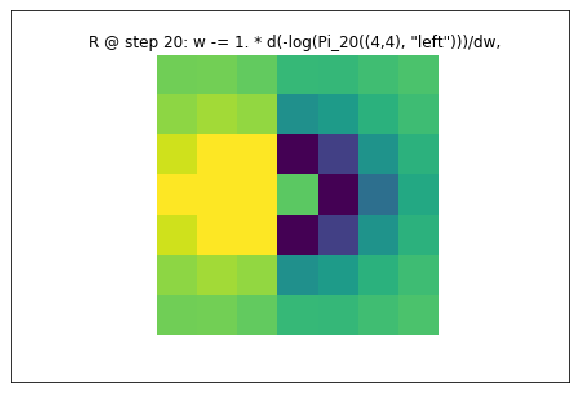

<Figure size 720x720 with 0 Axes>

In [199]:
Plotting.create_gif(lambda: gif_images, "./mlirl_gradient_effect_r_vi_20.gif", figsize=(10,10), fps=2)

<img src="./mlirl_gradient_effect_r.gif">

In [22]:
vi_params["given_goal_idx"] = 23
optimizer.zero_grad()
R_diff = torch.mm(phi_S, w)
tdiff, Pi, V, Q = exp_vi(vi_params, R_diff, 1)
loss = -torch.log(Pi[24,2])
loss.backward()

In [23]:
w.grad.reshape(7,7).data.numpy().round(2)

array([[ 0.09,  0.09,  0.06,  0.03,  0.  ,  0.  ,  0.  ],
       [ 0.11,  0.15,  0.14,  0.09,  0.  ,  0.  ,  0.  ],
       [ 0.07,  0.18,  0.3 ,  0.44, -0.01,  0.  ,  0.  ],
       [ 0.  ,  0.01,  0.  , -0.01,  0.14,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.14,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]], dtype=float32)

In [21]:
def run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, n_iters,
                        dtype, given_goal_idx=None, verbose=False):

    nS, nA = len(S), len(A)
    
    # Initialize Pi, V, & Q.
    Pi = torch.ones(nS, nA, dtype=dtype) / nA
    V = R.clone() # trick to initialize terminal states' value without running VI on it (no need for absorbing state).
    Q = R.reshape(nS, 1).repeat(1, nA).clone()
    
    # Force given goals to have 0 value
    if given_goal_idx is not None:
        V[given_goal_idx] = 0
        
    # Value iteration
    for _ in range(n_iters):
        for si, s in enumerate(S):
            
            # No need to compute value for terminal and given goal states.
            if s.is_terminal() or si == given_goal_idx:
                continue 
                
            for ai, a in enumerate(A):
                for sp in T[s][a]:
                    if verbose: print(s, "-", "{:5s}".format(a), "->", sp, "R: ", int(R[si]), "V_sp: ", int(V[s_to_idx[sp]]))
                    Q[si, ai] = R[si].clone() + \
                        gamma * T[s][a][sp] * V[s_to_idx[sp]].clone()
            Pi[si, :] = expl_policy(Q[si, :].clone())
            V[si] = Pi[si, :].clone().dot(Q[si, :].clone())
    return Pi, V, Q

In [22]:
def run_mlirl_step(tau_s_list, tau_a_list, S, phi_S, s_to_idx, A, a_to_idx, 
                   w, T, expl_policy, gamma, n_vi_iter, dtype, given_goal_idx):
    
    
    R = torch.mm(phi_S, w)
    Pi, V, Q = run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, n_vi_iter, dtype, given_goal_idx)
    loss = 0
    for tau_idx, tau_s in enumerate(tau_s_list):
        for sample_idx, s in enumerate(tau_s[:-1]):
            a_idx = a_to_idx[tau_a_list[tau_idx][sample_idx]]
            loss -= torch.log(Pi[s_to_idx[s], a_idx])
    loss.backward()
    return loss, w.grad

def run_mlirl_step_shared(tau_s_list, tau_a_list, S, phi_S, s_to_idx, A, a_to_idx,
                          w, T, expl_policy, gamma, n_vi_iter, dtype, given_goal_idx,
                          w_grad_queue):
    
    R = torch.mm(phi_S, w)
    Pi, V, Q = run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, n_vi_iter, dtype, given_goal_idx)
    
    loss = 0
    for tau_idx, tau_s in enumerate(tau_s_list):
        for sample_idx, s in enumerate(tau_s[:-1]):
            a_idx = a_to_idx[tau_a_list[tau_idx][sample_idx]]
            loss -= torch.log(Pi[s_to_idx[s], a_idx])
    loss.backward()
    w_grad_queue.put(w.grad)
    return loss, w.grad

In [23]:
def group_by_goals(traj_states_list, traj_actions_list):
    
    goal_to_traj_idx = defaultdict(lambda: defaultdict(lambda: []))
    
    for traj_idx, traj_states in enumerate(traj_states_list):
        goal_to_traj_idx[traj_states[-1]]["tau_s_list"].append(traj_states)
        goal_to_traj_idx[traj_states[-1]]["tau_a_list"].append(traj_actions_list[traj_idx])
    return goal_to_traj_idx

In [24]:
optimizer_fn = lambda params: optim.SGD(params, lr=0.001, weight_decay=1.)

# nvmdp, S, A, T, phi, s_to_idx = get_toy_irl_problem_no_goal(7, 7)
nvmdp, S, A, T, phi, s_to_idx = get_toy_irl_problem(7, 7, (5,5))
# nvmdp.visualize_grid(show_colorbar=True, show_rewards_colorbar=True)

a_to_idx = {a:ai for ai, a in enumerate(A)}

gamma = 0.80
dtype = torch.float
phi_dim = len(phi(S[0]))
boltzmann_beta = 10.
boltzmann_expl_policy = lambda Q, beta=boltzmann_beta: (beta*Q).softmax(dim=0)
argmax_expl_policy = lambda Q: torch.eye(len(Q))[Q.argmax()]

expl_policy = boltzmann_expl_policy

phi_S = torch.Tensor([phi(s) for s in S]).type(dtype)
# w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
w = Variable(-0.001 * torch.ones(phi_dim, 1).type(dtype), requires_grad=True)
optimizer = optimizer_fn([w])

tau_s_list, tau_a_list = nvmdp.sample_trajectories(20, 3, init_cell_types=nvmdp.nav_cell_types)
                                                   #policy=lambda s: np.random.choice(A))
goal_to_trajectories = group_by_goals(tau_s_list, tau_a_list)
goal_tau_list = list(goal_to_trajectories.items())

R = torch.mm(phi_S, w)
R.reshape(7,7)

tensor([[-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010]],
       grad_fn=<AsStridedBackward>)

In [25]:
w = Variable(-0.001 * torch.ones(phi_dim, 1).type(dtype), requires_grad=True)
optimizer = optimizer_fn([w])

tensor([[-0.0056, -0.0117, -0.0137, -0.0092, -0.0032, -0.0016, -0.0012],
        [-0.0040, -0.0067,  0.0070,  0.0013, -0.0010, -0.0012, -0.0011],
        [-0.0029, -0.0039,  0.0251,  0.0310,  0.0056, -0.0011, -0.0011],
        [-0.0027, -0.0041,  0.0028,  0.0103, -0.0014, -0.0013, -0.0012],
        [-0.0030, -0.0057, -0.0063,  0.0006, -0.0038, -0.0020, -0.0014],
        [-0.0026, -0.0041, -0.0084, -0.0061, -0.0054, -0.0024, -0.0016],
        [-0.0022, -0.0030, -0.0047, -0.0064, -0.0037, -0.0021, -0.0015]],
       grad_fn=<AsStridedBackward>)


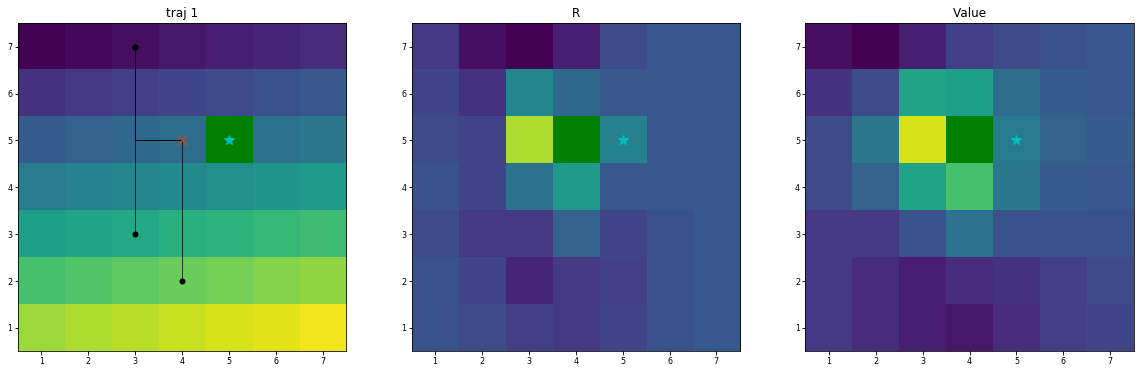

In [26]:
plt.figure(figsize=(20,14))
traj_idx = 0

optimizer.zero_grad()
tau_s_list, tau_a_list = goal_tau_list[traj_idx][1]["tau_s_list"], goal_tau_list[traj_idx][1]["tau_a_list"]
loss, w_grad = run_mlirl_step(tau_s_list, tau_a_list, S, phi_S, s_to_idx, A, a_to_idx, 
                               w, T, expl_policy, gamma, 10, dtype, None)

optimizer.step()
R = torch.mm(phi_S, w)
print(R.reshape(7,7))
Pi, V, Q = run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, 100,
                        dtype, given_goal_idx=None, verbose=False)
nvmdp.visualize_grid(trajectories=tau_s_list, end_marker="x", title="traj {}".format(traj_idx+1), 
                     new_fig=False, subplot_str="131")
nvmdp.visualize_grid(R.reshape(7,7).data.numpy(), title="R", new_fig=False, subplot_str="132")
nvmdp.visualize_grid(V.reshape(7,7).data.numpy(), title="Value", new_fig=False, subplot_str="133")
# plt.imshow()

tensor([[-0.0101, -0.0224, -0.0264, -0.0172, -0.0052, -0.0018, -0.0014],
        [-0.0071, -0.0125,  0.0150,  0.0037, -0.0006,  0.0002, -0.0015],
        [-0.0048, -0.0069,  0.0510,  0.0628,  0.0138,  0.0063,  0.0061],
        [-0.0045, -0.0073,  0.0064,  0.0213, -0.0023, -0.0027,  0.0008],
        [-0.0050, -0.0104, -0.0118,  0.0018, -0.0078, -0.0072, -0.0087],
        [-0.0041, -0.0073, -0.0160, -0.0115, -0.0105, -0.0060, -0.0074],
        [-0.0033, -0.0050, -0.0084, -0.0119, -0.0069, -0.0045, -0.0042]],
       grad_fn=<AsStridedBackward>)


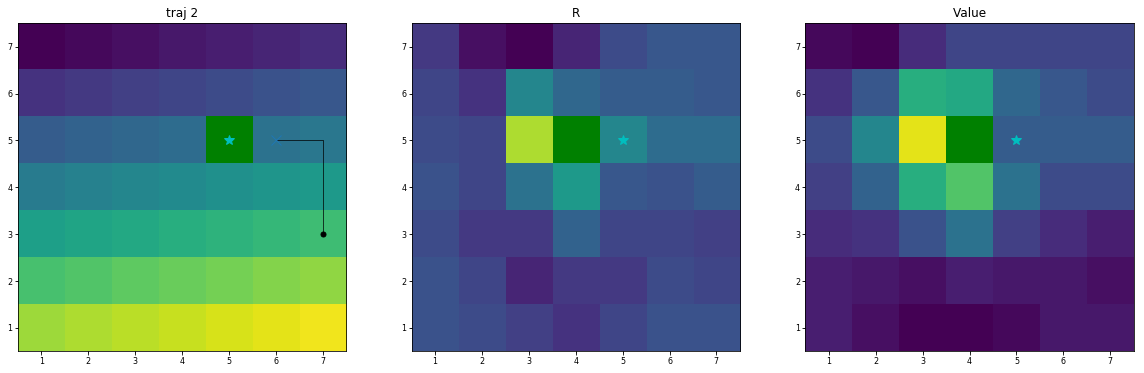

In [27]:
plt.figure(figsize=(20,14))
traj_idx = 1

# w = Variable(-0.01 * torch.ones(phi_dim, 1).type(dtype), requires_grad=True)
# optimizer.zero_grad()
# optimizer = optimizer_fn([w])

tau_s_list, tau_a_list = goal_tau_list[1][1]["tau_s_list"], goal_tau_list[1][1]["tau_a_list"]
loss, w_grad = run_mlirl_step(tau_s_list, tau_a_list, S, phi_S, s_to_idx, A, a_to_idx, 
                               w, T, expl_policy, gamma, 10, dtype, None)

optimizer.step()
R = torch.mm(phi_S, w)
print(R.reshape(7,7))
Pi, V, Q = run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, 100,
                        dtype, given_goal_idx=None, verbose=False)

nvmdp.visualize_grid(trajectories=tau_s_list, end_marker="x", title="traj {}".format(traj_idx+1), 
                     new_fig=False, subplot_str="131")
nvmdp.visualize_grid(R.reshape(7,7).data.numpy(), title="R", new_fig=False, subplot_str="132")
nvmdp.visualize_grid(V.reshape(7,7).data.numpy(), title="Value", new_fig=False, subplot_str="133")


In [28]:
w = Variable(-0.001 * torch.ones(phi_dim, 1).type(dtype), requires_grad=True)
optimizer_fn = lambda params: optim.SGD(params, lr=0.0001, weight_decay=1.)
optimizer = optimizer_fn([w])

w_grad_queue = mp.Queue()

for i in range(4):
    
    optimizer.zero_grad()
    processes = []
    t_ = time.time()
    for idx in range(5):
        tau_s_list, tau_a_list = goal_tau_list[idx][1]["tau_s_list"], goal_tau_list[idx][1]["tau_a_list"]
        p = mp.Process(target=run_mlirl_step_shared, args=(tau_s_list, tau_a_list, S, phi_S, s_to_idx, A, a_to_idx, 
                                                    w, T, expl_policy, gamma, 20, dtype, None, w_grad_queue))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
    print(time.time()-t_)
    while not w_grad_queue.empty():
        if w.grad is not None:
            w.grad += w_grad_queue.get_nowait()
        else:
            w.grad = w_grad_queue.get_nowait()
    optimizer.step()

1.3407349586486816
1.4647512435913086
1.5815868377685547
1.3454620838165283


tensor([[-0.0264, -0.0608, -0.0900, -0.0980, -0.0850, -0.0781, -0.0643],
        [-0.0247, -0.0612, -0.0258, -0.1215, -0.0399, -0.0600, -0.0733],
        [-0.0320, -0.0647,  0.0216,  0.1245,  0.3999,  0.1113,  0.0285],
        [-0.0198, -0.0436, -0.0486, -0.0304, -0.0778, -0.0632, -0.0161],
        [-0.0168, -0.0355, -0.0650, -0.0084, -0.0839, -0.0847, -0.0667],
        [-0.0147, -0.0252, -0.0679, -0.0313, -0.0681, -0.0701, -0.0809],
        [-0.0144, -0.0238, -0.0520, -0.0769, -0.0537, -0.0390, -0.0534]],
       grad_fn=<AsStridedBackward>)


/Users/yrevar/.pyenv/versions/irl_python3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


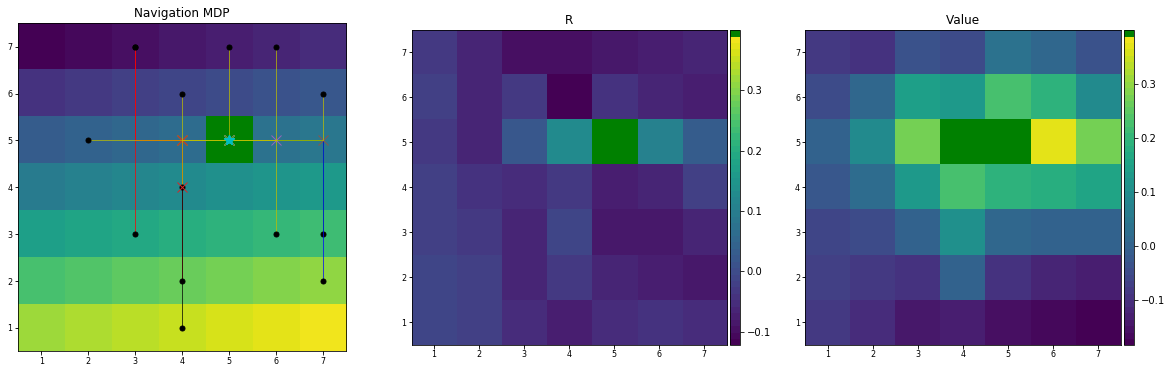

In [29]:
plt.figure(figsize=(20,14))
R = torch.mm(phi_S, w)
print(R.reshape(7,7))
Pi, V, Q = run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, 100,
                        dtype, given_goal_idx=None, verbose=False)

# sum([goal_tau_list[i][1]["tau_s_list"] for i in range(5)], [])
marker_colors = ["r", "g", "b", "y", "k"]
for i in range(5):
    nvmdp.visualize_grid(trajectories=goal_tau_list[i][1]["tau_s_list"],
                         end_marker="x", title="Navigation MDP",
                         new_fig=False, subplot_str="131", traj_marker=marker_colors[i])
    
nvmdp.visualize_grid(R.reshape(7,7).data.numpy(), title="R", new_fig=False, subplot_str="132", 
                     show_colorbar=True, goal_marker="")
nvmdp.visualize_grid(V.reshape(7,7).data.numpy(), title="Value", new_fig=False, subplot_str="133",
                    show_colorbar=True, goal_marker="")

In [30]:
def run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, n_iters,
                        dtype, given_goal_idx=None, verbose=False):

    nS, nA = len(S), len(A)
    
    # Initialize Pi, V, & Q.
    Pi = torch.ones(nS, nA, dtype=dtype) / nA
    V = R.clone() # trick to initialize terminal states' value without running VI on it (no need for absorbing state).
    Q = R.reshape(nS, 1).repeat(1, nA).clone()
    
    # Force given goals to have 0 value
    if given_goal_idx is not None:
        V[given_goal_idx] = 0
        
    # Value iteration
    for _ in range(n_iters):
        for si, s in enumerate(S):
            
            # No need to compute value for terminal and given goal states.
            if s.is_terminal() or si == given_goal_idx:
                continue 
                
            for ai, a in enumerate(A):
                for sp in T[s][a]:
                    if verbose: print(s, "-", "{:5s}".format(a), "->", sp, "R: ", int(R[si]), "V_sp: ", int(V[s_to_idx[sp]]))
                    Q[si, ai] = R[si].clone() + \
                        gamma * T[s][a][sp] * V[s_to_idx[sp]].clone()
            Pi[si, :] = expl_policy(Q[si, :].clone())
            V[si] = Pi[si, :].clone().dot(Q[si, :].clone())
    return Pi, V, Q

def compute_gradient(tau_s_list, tau_a_list, S, phi_S, s_to_idx, A, a_to_idx,
                          w, T, expl_policy, gamma, n_vi_iter, dtype, given_goal_idx,
                          w_grad_queue):
    print("called... wtf")
    R = torch.mm(phi_S, w)
    print("hmm")
    
    Pi, V, Q = run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, n_vi_iter, dtype, given_goal_idx)
    print("ran vi...", flush=True)
    
    loss = 0
    for tau_idx, tau_s in enumerate(tau_s_list):
        for sample_idx, s in enumerate(tau_s[:-1]):
            a_idx = a_to_idx[tau_a_list[tau_idx][sample_idx]]
            loss -= torch.log(Pi[s_to_idx[s], a_idx])
    print(loss)
    loss.backward()
    w_grad_queue.put(w.grad)
    return loss, w.grad


def run_mlirl_step_by_goals(tau_by_goals, S, s_to_idx, phi_S, A, a_to_idx, w, T, 
                            expl_policy, gamma, vi_iters, dtype, given_goal):

    w_grad_queue = mp.Queue()
    processes = []

    for goal in tau_by_goals.keys():
        
        tau_s_list = tau_by_goals[goal]["tau_s_list"]
        tau_a_list = tau_by_goals[goal]["tau_a_list"]
#         compute_gradient(tau_s_list, tau_a_list, S, phi_S, s_to_idx, 
#                            A, a_to_idx, w, T, expl_policy, gamma, 
#                            vi_iters, dtype, s_to_idx[goal] if given_goal else None, 
#                            w_grad_queue)
        p = mp.Process(target=compute_gradient, args=(tau_s_list, tau_a_list, S, phi_S, s_to_idx, 
                                                           A, a_to_idx, w, T, expl_policy, gamma, 
                                                           vi_iters, dtype, s_to_idx[goal] if given_goal else None, 
                                                           w_grad_queue))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        
    while not w_grad_queue.empty():
        if w.grad is not None:
            w.grad += w_grad_queue.get_nowait()
        else:
            w.grad = w_grad_queue.get_nowait()
    return w.grad

In [3]:
w = Variable(-0.001 * torch.ones(phi_dim, 1).type(dtype), requires_grad=True)
optimizer_fn = lambda params: optim.SGD(params, lr=0.0001, weight_decay=1.)
optimizer = optimizer_fn([w])
run_mlirl_step_by_goals(goal_to_trajectories, S, s_to_idx, phi_S, A, a_to_idx, w, T,
                        expl_policy, gamma, 20, dtype, False)
optimizer.step()

NameError: name 'run_mlirl_step_by_goals' is not defined

tensor([[-0.0018, -0.0024, -0.0027, -0.0030, -0.0028, -0.0027, -0.0026],
        [-0.0019, -0.0020, -0.0004, -0.0015, -0.0013, -0.0015, -0.0022],
        [-0.0009,  0.0016,  0.0043,  0.0045,  0.0047,  0.0017,  0.0005],
        [-0.0023, -0.0006, -0.0009,  0.0004, -0.0015, -0.0004, -0.0006],
        [-0.0036, -0.0023, -0.0028, -0.0009, -0.0023, -0.0017, -0.0023],
        [-0.0029, -0.0024, -0.0030, -0.0019, -0.0027, -0.0022, -0.0031],
        [-0.0025, -0.0027, -0.0029, -0.0029, -0.0028, -0.0028, -0.0030]],
       grad_fn=<AsStridedBackward>)


/Users/yrevar/.pyenv/versions/irl_python3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


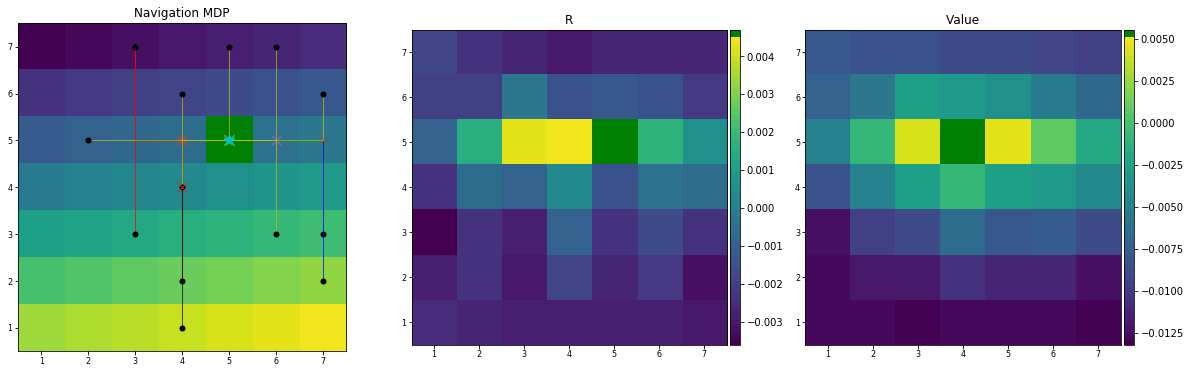

In [32]:
plt.figure(figsize=(20,14))
R = torch.mm(phi_S, w)
print(R.reshape(7,7))
Pi, V, Q = run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, 100,
                        dtype, given_goal_idx=None, verbose=False)

# sum([goal_tau_list[i][1]["tau_s_list"] for i in range(5)], [])
marker_colors = ["r", "g", "b", "y", "k"]
for i in range(5):
    nvmdp.visualize_grid(trajectories=goal_tau_list[i][1]["tau_s_list"],
                         end_marker="x", title="Navigation MDP",
                         new_fig=False, subplot_str="131", traj_marker=marker_colors[i])
    
nvmdp.visualize_grid(R.reshape(7,7).data.numpy(), title="R", new_fig=False, subplot_str="132", 
                     show_colorbar=True, goal_marker="")
nvmdp.visualize_grid(V.reshape(7,7).data.numpy(), title="Value", new_fig=False, subplot_str="133",
                    show_colorbar=True, goal_marker="")

In [42]:
phi_S.dtype

torch.float32

In [58]:
def test(phi_S, w):
    print("start")
    phi_S.mm(w)
    print("end")
    
dtype = torch.float
phi_dim = 10
phi_S = torch.rand(10000, phi_dim).type(dtype)
w = Variable(-0.001 * torch.ones(phi_dim, 1).type(dtype), requires_grad=True)
processes = []
for p_idx in range(8):
    p = mp.Process(target=test, args=(phi_S, w))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

start
end
start
start
end
end
start
end
start
end
start
end
start
end
start
end


In [18]:
def test(q):
    var = q.get()
    print(var)
    var.append(1)
    q.put(var)

In [19]:
v = [1]
# mp.set_start_method('fork')
processes = []
q = mp.Queue()
q.put(v)
for idx in range(2):
    p = mp.Process(target=test, args=(q,))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()

[1]
[1, 1]


In [20]:
q.get()

[1, 1, 1]

In [21]:
from multiprocessing import Pool

def f(x):
    return x*x

if __name__ == '__main__':
    with Pool(4) as p:
        print(p.map(f, [1, 2, 3]))

[1, 4, 9]


tensor([[-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010]],
       grad_fn=<AsStridedBackward>)


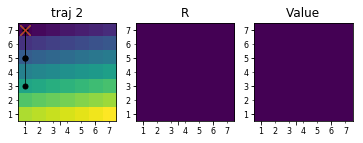

In [301]:
R = torch.mm(phi_S, w)
print(R.reshape(7,7))
Pi, V, Q = run_value_iteration(S, A, R, T, s_to_idx, expl_policy, gamma, 100,
                        dtype, given_goal_idx=None, verbose=False)

nvmdp.visualize_grid(trajectories=tau_s_list, end_marker="x", title="traj {}".format(traj_idx+1), 
                     new_fig=False, subplot_str="131")
nvmdp.visualize_grid(R.reshape(7,7).data.numpy(), title="R", new_fig=False, subplot_str="132")
nvmdp.visualize_grid(V.reshape(7,7).data.numpy(), title="Value", new_fig=False, subplot_str="133")

In [ ]:
def compute_policy(S, A, R, T, idx_to_s, gamma, n_iters,
                   expl_policy, dtype, given_goal_idx=None):

    nS, nA = len(S), len(A)
    # Policy
    Pi = torch.ones(nS, nA, dtype=dtype) / nA
    # Value
    V = R[:, 0].clone()
    # Q value
    Q = R.repeat(1, nA).clone()

    # Check if state is terminal (stop leaking values back to
    # non-goal state space)
    # Done here so as to impro.ve performance.
    S_ = [si for si in S if not (
        idx_to_s[si].is_terminal() or given_goal_idx == si)]

    if given_goal_idx:
        V[given_goal_idx] = 0

    # Value iteration
    for _vi_iter in range(n_iters):
        for si in S_:
            for ai in A:
                Q[si, ai] = R[si].clone() + gamma * T[si][ai].dot(V.clone())
            Pi[si, :] = expl_policy(Q[si, :].clone())
            V[si] = Pi[si, :].clone().dot(Q[si, :].clone())
    return Pi, V, Q

In [2]:
def run_value_iteration(S, A, R, trans_dict, s_to_idx, gamma, n_iters, expl_policy, dtype, 
                        given_goal_idx=None, perf_debug=False):
    
    _vi_start = time.time()
    
    nS, nA = len(S), len(A)
    # Policy
    Pi = torch.ones(nS, nA, dtype=dtype) / nA
    # Value
    V = R[:,0].clone()
    # Q value
    Q = R.repeat(1,nA).clone()
    
    if given_goal_idx:
        V[given_goal_idx] = 0
            
    # Value iteration
    for _vi_iter in range(n_iters):

        for s_idx, s in enumerate(S):
            # Check if state is terminal (stop leaking values back to non-goal state space)
            if s.is_terminal() or (given_goal_idx and s_idx == given_goal_idx):
                continue
            for a_idx, a in enumerate(A):
                Q[s_idx, a_idx] = R[s_idx]
                for s_prime in trans_dict[s][a]:
                    Q[s_idx, a_idx] += gamma * trans_dict[s][a][s_prime] * V[s_to_idx[s_prime]].clone()
            Pi[s_idx, :] = expl_policy(Q[s_idx,:].clone())
            V[s_idx] = Pi[s_idx, :].clone().dot(Q[s_idx,:].clone())
    return time.time()-_vi_start, Pi, V, Q

def compute_loss(Pi, traj_S, traj_A):
    
    nS, nA = Pi.shape
    loss = 0.
    for i in range(len(traj_S)):
        loss -= torch.log(Pi[traj_S[i], traj_A[i]])
    return loss

def dummy_max_likelihood_gradient_step(Pi, n_samples):
    
    nS, nA = Pi.shape
    traj_S = [np.random.choice(nS) for _ in range(n_samples)]
    traj_A = [np.random.choice(nA) for _ in range(n_samples)]
    loss = compute_loss(Pi, traj_S, traj_A)
    loss.backward()
    
def run_dummy_mlirl(phi_S, w, vi_vars, n_iters, n_traj_points, optimizer):
    
    optimizer.zero_grad()
    vi_vars["R"] = torch.mm(phi_S, w)
    t, Pi, V, Q = run_value_iteration(**vi_vars, n_iters=n_iters)
    _t = time.time()
    dummy_max_likelihood_gradient_step(Pi, n_traj_points)
    return (time.time() - _t + t, )

def compute_perf(fn, var_values, n_rep):
    
    run_times = []
    for var_value in var_values:
        
        #ts = time.time()
        ts = 0
        for _ in range(n_rep):
            ts += fn(var_value)[0]
        run_times.append(ts/n_rep)
        
    return run_times

### GridWorld MDP (3x5)

In [6]:
gamma = 0.95
dtype = torch.float
optimizer_fn = lambda params: optim.SGD(params, lr=1., weight_decay=0.)

mdp = GridWorldMDP(width=5, height=2)
value_iter = ValueIteration(mdp)
value_iter._compute_matrix_from_trans_func()

S = value_iter.get_states()
trans_dict = value_iter.trans_dict
A = mdp.get_actions()
s_to_idx = {s:idx for idx,s in enumerate(S)}

phi_S = torch.Tensor([(s.x, s.y) for s in S]).type(dtype)
phi_dim = phi_S.shape[1]

w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
R = torch.mm(phi_S, w)
R_const = torch.Tensor(len(S), 1).normal_(0, 0.01).type(dtype)

# Optimization params
optimizer = optimizer_fn([w])

# Exploration policy
boltzmann_beta = 1.
expl_policy = lambda Q: (boltzmann_beta*Q).softmax(dim=0)
given_goal_idx = None
vi_vars = dict(S=S, A=A, trans_dict=trans_dict, s_to_idx=s_to_idx, 
               gamma=gamma, expl_policy=expl_policy, dtype=dtype, given_goal_idx=given_goal_idx)

In [19]:
vi_vars["R"] = R_const

In [55]:
times = []
for num_processes in range(1,20):
    # model = MyModel()
    # NOTE: this is required for the ``fork`` method to work
    # model.share_memory()
    processes = []
    s = time.time()

    for rank in range(num_processes):
        p = mp.Process(target=lambda: run_value_iteration(**vi_vars, n_iters=100), args=())
        p.start()
        processes.append(p)
    for p in processes:
        p.join()

    times.append(time.time()-s)

In [63]:
means = np.arange(10)
stds = np.random.normal(size=10)

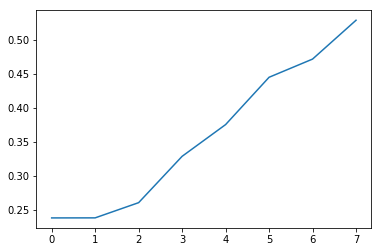

In [58]:
plt.plot(times[:8])

In [51]:
s = time.time()
for i in range(4):
    run_value_iteration(**vi_vars, n_iters=100)
print(time.time()-s)

0.880897045135498


## VI Runtime by # of iterations (fixed states)

In [4]:
iter_range = list(range(1,11)) #+ list(range(20,110,10)) #+ [150,200,250,300,350,400,500]
n_rep = 10
n_traj_points = 10
vi_vars["R"] = R_const
rt_vi_no_diff_param = compute_perf(lambda n_iters: run_value_iteration(**vi_vars, n_iters=n_iters), 
                          iter_range, n_rep)
vi_vars["R"] = R
rt_vi_diff_param = compute_perf(lambda n_iters: run_value_iteration(**vi_vars, n_iters=n_iters), 
                       iter_range, n_rep)
rt_vi_backward = compute_perf(lambda n_iters: run_dummy_mlirl(phi_S, w, vi_vars, n_iters=n_iters, 
                                                                n_traj_points=n_traj_points,
                                                                optimizer=optimizer),
                                iter_range, n_rep)
mean_iter = lambda x: (np.array(x) / iter_range).mean()
mean_rt_vi_no_diff_param = mean_iter(rt_vi_no_diff_param)
mean_rt_vi_diff_param = mean_iter(rt_vi_diff_param)
mean_rt_vi_backward = mean_iter(rt_vi_backward)

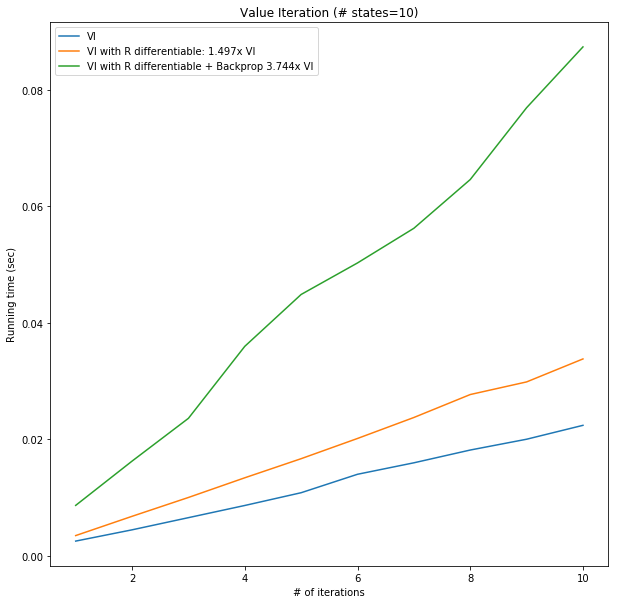

In [5]:
plt.figure(figsize=(10,10))
plt.plot(iter_range, rt_vi_no_diff_param, label="VI")
plt.plot(iter_range, rt_vi_diff_param, label="VI with R differentiable: {:.3f}x VI".format(
                                                                        mean_rt_vi_diff_param/mean_rt_vi_no_diff_param))
plt.plot(iter_range, rt_vi_backward, label="VI with R differentiable + Backprop {:.3f}x VI".format(
                                                                        mean_rt_vi_backward/mean_rt_vi_no_diff_param))
plt.title("Value Iteration (# states={})".format(mdp.width*mdp.height))
plt.xlabel("# of iterations")
plt.ylabel("Running time (sec)")
plt.legend()

In [6]:
n_rep = 10
n_traj_point_range = list(range(1,11)) + list(range(20,110,10))
rt_vi_backward_ = compute_perf(lambda n_traj_points: run_dummy_mlirl(phi_S, w, vi_vars, n_iters=10,
                                                                n_traj_points=n_traj_points,
                                                                optimizer=optimizer),
                                n_traj_point_range, n_rep)

Text(0,0.5,'Running time (sec)')

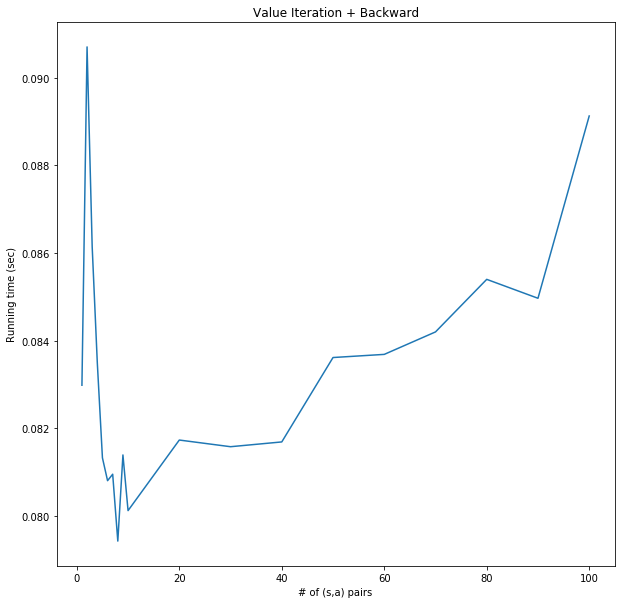

In [7]:
plt.figure(figsize=(10,10))
plt.plot(n_traj_point_range, rt_vi_backward_)
plt.title("Value Iteration + Backward")
plt.xlabel("# of (s,a) pairs")
plt.ylabel("Running time (sec)")

## VI Runtime by # of states (fixed iterations)

In [8]:
def run_vi_by_grid_size(w, h, Rdiff=False, vi_iters=10):
    
    mdp = GridWorldMDP(width=w, height=h)
    value_iter = ValueIteration(mdp)
    value_iter._compute_matrix_from_trans_func()

    S = value_iter.get_states()
    trans_dict = value_iter.trans_dict
    A = mdp.get_actions()
    s_to_idx = {s:idx for idx,s in enumerate(S)}

    phi_S = torch.Tensor([(s.x, s.y) for s in S]).type(dtype)
    phi_dim = phi_S.shape[1]

    w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
    R = torch.mm(phi_S, w)
    R_const = torch.Tensor(len(S), 1).normal_(0, 0.01).type(dtype)

    # Optimization params
    optimizer = optimizer_fn([w])

    vi_vars = dict(S=S, A=A, trans_dict=trans_dict, s_to_idx=s_to_idx, 
                   gamma=gamma, expl_policy=expl_policy, dtype=dtype, given_goal_idx=given_goal_idx)
    
    if Rdiff:
        vi_vars["R"] = R
    else:
        vi_vars["R"] = R_const
        
    return run_value_iteration(**vi_vars, n_iters=vi_iters)
    
def run_dummy_mlirl_by_grid_size(w, h, vi_iters=10, n_traj_points=10):
    
    mdp = GridWorldMDP(width=w, height=h)
    value_iter = ValueIteration(mdp)
    value_iter._compute_matrix_from_trans_func()

    S = value_iter.get_states()
    trans_dict = value_iter.trans_dict
    A = mdp.get_actions()
    s_to_idx = {s:idx for idx,s in enumerate(S)}

    phi_S = torch.Tensor([(s.x, s.y) for s in S]).type(dtype)
    phi_dim = phi_S.shape[1]

    w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)

    # Optimization params
    optimizer = optimizer_fn([w])

    vi_vars = dict(S=S, A=A, trans_dict=trans_dict, s_to_idx=s_to_idx, 
                   gamma=gamma, expl_policy=expl_policy, dtype=dtype, given_goal_idx=given_goal_idx)
    
    optimizer.zero_grad()
    vi_vars["R"] = torch.mm(phi_S, w)
    t, Pi, V, Q = run_value_iteration(**vi_vars, n_iters=vi_iters)
    _t = time.time()
    dummy_max_likelihood_gradient_step(Pi, n_traj_points)
    return (time.time() - _t + t, )

In [9]:
grid_nodes_range = list(range(1,11)) + list(range(20,110,10))
n_rep = 3
n_traj_points = 10
nH = 2

rt_vi_no_diff_param = compute_perf(lambda w: run_vi_by_grid_size(w,h=nH,Rdiff=False,vi_iters=10), 
                                   grid_nodes_range, n_rep)

rt_vi_diff_param = compute_perf(lambda w: run_vi_by_grid_size(w,h=nH,Rdiff=True,vi_iters=10), 
                                   grid_nodes_range, n_rep)

rt_vi_backward = compute_perf(lambda w: run_dummy_mlirl_by_grid_size(w,h=nH,vi_iters=10,n_traj_points=n_traj_points), 
                                   grid_nodes_range, n_rep)

states = nH*np.array(grid_nodes_range)
mean_iter = lambda x: (np.array(x) / states).mean()
mean_rt_vi_no_diff_param = mean_iter(rt_vi_no_diff_param)
mean_rt_vi_diff_param = mean_iter(rt_vi_diff_param)
mean_rt_vi_backward = mean_iter(rt_vi_backward)

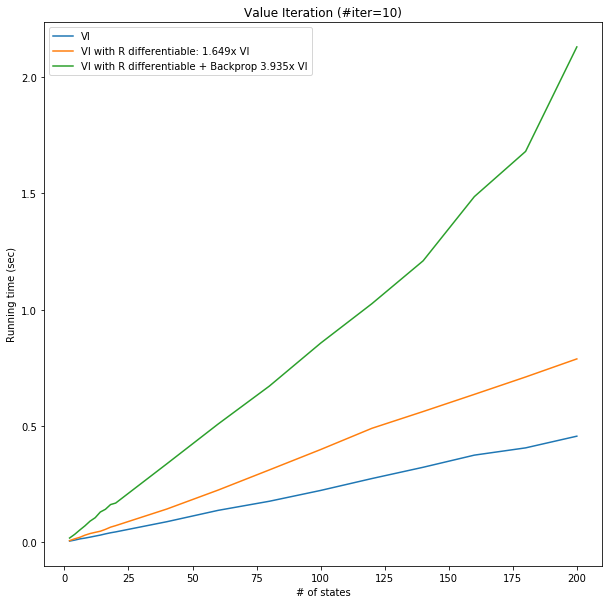

In [10]:
plt.figure(figsize=(10,10))
plt.plot(states, rt_vi_no_diff_param, label="VI")
plt.plot(states, rt_vi_diff_param, 
         label="VI with R differentiable: {:.3f}x VI".format(
                mean_rt_vi_diff_param/mean_rt_vi_no_diff_param))
plt.plot(states, rt_vi_backward, 
         label="VI with R differentiable + Backprop {:.3f}x VI".format(
                mean_rt_vi_backward/mean_rt_vi_no_diff_param))
plt.title("Value Iteration (#iter={})".format(10))
plt.xlabel("# of states")
plt.ylabel("Running time (sec)")
plt.legend()

In [11]:
def run_vi_by_phi_dim(phi_dim, w=5, h=2, Rdiff=False, vi_iters=10):
    mdp = GridWorldMDP(width=w, height=h)
    value_iter = ValueIteration(mdp)
    value_iter._compute_matrix_from_trans_func()

    S = value_iter.get_states()
    trans_dict = value_iter.trans_dict
    A = mdp.get_actions()
    s_to_idx = {s:idx for idx,s in enumerate(S)}

    phi_S = torch.Tensor(len(S), phi_dim).normal_(0, 0.01).type(dtype)

    w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
    R = torch.mm(phi_S, w)
    R_const = torch.Tensor(len(S), 1).normal_(0, 0.01).type(dtype)

    # Optimization params
    optimizer = optimizer_fn([w])

    vi_vars = dict(S=S, A=A, trans_dict=trans_dict, s_to_idx=s_to_idx, 
                   gamma=gamma, expl_policy=expl_policy, dtype=dtype, given_goal_idx=given_goal_idx)
    if Rdiff:
        vi_vars["R"] = R
    else:
        vi_vars["R"] = R_const
    return run_value_iteration(**vi_vars, n_iters=vi_iters)
    
def run_dummy_mlirl_by_grid_size(phi_dim, w=5, h=2, vi_iters=10, n_traj_points=10):
    
    mdp = GridWorldMDP(width=w, height=h)
    value_iter = ValueIteration(mdp)
    value_iter._compute_matrix_from_trans_func()

    S = value_iter.get_states()
    trans_dict = value_iter.trans_dict
    A = mdp.get_actions()
    s_to_idx = {s:idx for idx,s in enumerate(S)}

    phi_S = torch.Tensor([(s.x, s.y) for s in S]).type(dtype)
    phi_dim = phi_S.shape[1]

    w = Variable(torch.Tensor(phi_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
    R = torch.mm(phi_S, w)
    R_const = torch.Tensor(len(S), 1).normal_(0, 0.01).type(dtype)

    # Optimization params
    optimizer = optimizer_fn([w])

    vi_vars = dict(S=S, A=A, trans_dict=trans_dict, s_to_idx=s_to_idx, 
                   gamma=gamma, expl_policy=expl_policy, dtype=dtype, given_goal_idx=given_goal_idx)
    
    optimizer.zero_grad()
    vi_vars["R"] = torch.mm(phi_S, w)
    t, Pi, V, Q = run_value_iteration(**vi_vars, n_iters=vi_iters)
    _t = time.time()
    dummy_max_likelihood_gradient_step(Pi, n_traj_points)
    return (time.time() - _t + t, )

In [12]:
phi_dim_range = list(range(1,11)) + list(range(20,110,10)) + [128,160,192,256]
n_rep = 3
n_traj_points = 10
nH = 2
nW = 5

rt_vi_no_diff_param = compute_perf(lambda phi_dim: run_vi_by_phi_dim(phi_dim,nW,nH,Rdiff=False,vi_iters=10), 
                                   phi_dim_range, n_rep)

rt_vi_diff_param = compute_perf(lambda w: run_vi_by_phi_dim(phi_dim,nW,nH,Rdiff=True,vi_iters=10), 
                                   phi_dim_range, n_rep)

rt_vi_backward = compute_perf(lambda w: run_dummy_mlirl_by_grid_size(phi_dim,nW,nH,vi_iters=10,n_traj_points=n_traj_points),
                                   phi_dim_range, n_rep)


mean_iter = lambda x: (np.array(x) / phi_dim_range).mean()
mean_rt_vi_no_diff_param = mean_iter(rt_vi_no_diff_param)
mean_rt_vi_diff_param = mean_iter(rt_vi_diff_param)
mean_rt_vi_backward = mean_iter(rt_vi_backward)

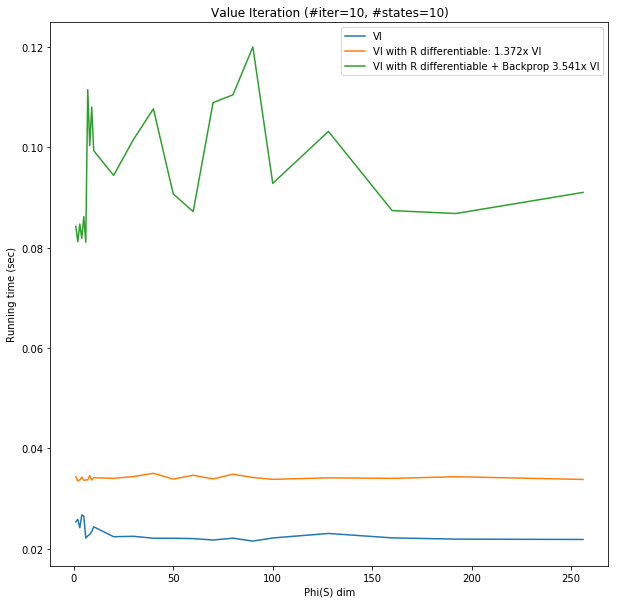

In [13]:
plt.figure(figsize=(10,10))
plt.plot(phi_dim_range, rt_vi_no_diff_param, label="VI")
plt.plot(phi_dim_range, rt_vi_diff_param, 
         label="VI with R differentiable: {:.3f}x VI".format(
                mean_rt_vi_diff_param/mean_rt_vi_no_diff_param))
plt.plot(phi_dim_range, rt_vi_backward, 
         label="VI with R differentiable + Backprop {:.3f}x VI".format(
                mean_rt_vi_backward/mean_rt_vi_no_diff_param))
plt.title("Value Iteration (#iter={}, #states={})".format(10,nH*nW))
plt.xlabel("Phi(S) dim")
plt.ylabel("Running time (sec)")
plt.legend()